In [77]:
import os
import numpy as np
import math

os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, njit, vectorize, cuda 
from numba import vectorize, float32

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [78]:
A = [2,5,10,3,8]

@vectorize([float32(float32)], target='parallel', fastmath=True) 

def vlog(x):
    l = np.log(x)
    return l

def vexp(x):
    e = np.exp(x)
    return e

a = np.array(A).astype(np.float32) 

print("A: ", A)
print("Vectorized log(A):", vlog(a))
print("Vectorized exp(A):", vexp(a))


A:  [2, 5, 10, 3, 8]
Vectorized log(A): [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
Vectorized exp(A): [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]


## Exercise 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [79]:
@jit
def gauss(mu, sigma, low, upp, size):
    X = np.linspace(low, upp, size)
    return np.exp( ((X-mu)**2)/(2*sigma**2) )/np.sqrt(2*np.pi*sigma**2)

gauss(1,1,-3,3,100000)

array([1189.23017713, 1188.94479542, 1188.65948648, ...,    2.94709952,
          2.94745318,    2.94780689])

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$threshold = 15$

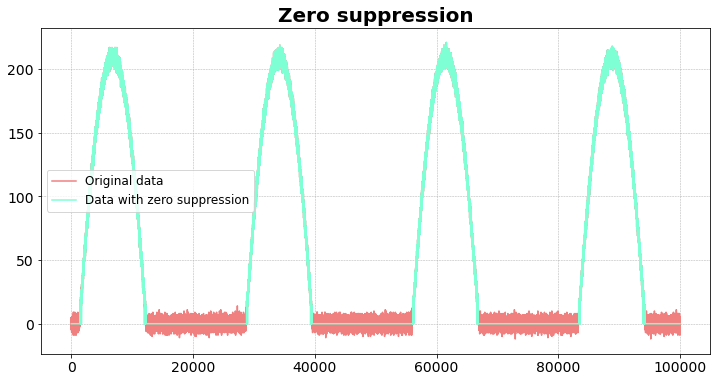

In [80]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)
thr = 15 

@jit
def zero_supp(data, thr):
    zs_data = data.copy() #to compare with the original
    for i in range(len(data)):
        if zs_data[i] < thr : 
            zs_data[i] = 0
    return zs_data
    
zs_data = zero_supp(data, thr)

plt.figure(figsize=(12,6))
plt.plot(np.arange(n), data, c="lightcoral", label = "Original data")
plt.plot(np.arange(n), zs_data, c="aquamarine", label="Data with zero suppression")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.grid(linestyle="--", linewidth=0.5)
plt.title("Zero suppression", fontweight='bold', fontsize=20)
plt.show() 

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [81]:
# Using numpy
X = np.random.rand(3,3)
Y = np.random.rand(3,3)
# choose random value btwn 0 and 1 for alpha and c
alpha = np.random.rand() 
c = np.random.rand() 
K = np.tanh( alpha*np.dot(np.transpose(X), Y) + c ) 
print(K)

[[0.67963703 0.6759949  0.61780765]
 [0.54974589 0.46938235 0.48678716]
 [0.58984989 0.51394761 0.52017647]]


In [82]:
#with kernel
@cuda.jit
def sigmoid_kernel(X,Y,alpha,c,K):
    row, col = cuda.grid(2)
    if row < K.shape[0] and col < K.shape[1]:
        tmp = 0.
        for i in range(X.shape[1]):
            tmp += X[i, row] * Y[i, col]
        K[row, col] = np.tanh(alpha*tmp+c)

K = np.zeros(9).reshape(3,3) 
    
threadsperblock = (3,3)
blockspergrid_x = int(math.ceil(X.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(Y.shape[0] / threadsperblock[0]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

sigmoid_kernel[threadsperblock, blockspergrid](X,Y, alpha, c, K)
print(K)


[[0.67963703 0.6759949  0.61780765]
 [0.54974589 0.46938235 0.48678716]
 [0.58984989 0.51394761 0.52017647]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [54]:
# CUDA kernel
@cuda.jit
def double_kernel_3D(io_array):
    row, col, wid = cuda.grid(3)
    if row < io_array.shape[0] and col < io_array.shape[1] and wid < io_array.shape[2]:
        io_array[row][col][wid] = math.cos(io_array[row][col][wid])

# Host code   
data = np.random.rand(256,256,256)

# Configure the blocks
threadsperblock = (16, 4, 4) #ThreadsPerBlock must be a divisor of the data dimension: 256/16/4/4 = 1
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

double_kernel_3D[blockspergrid, threadsperblock](data)
print(data)


[[[0.99112896 0.65935992 0.55121955 ... 0.2535191  0.8996902  0.86043482]
  [0.58335617 0.54518723 0.99099003 ... 0.17052305 0.47847919 0.35145579]
  [0.99993777 0.92355015 0.72870779 ... 0.11481252 0.86044213 0.99525528]
  ...
  [0.99883731 0.68867411 0.95097775 ... 0.85393591 0.9131638  0.52015139]
  [0.95009047 0.99823006 0.69237163 ... 0.74951228 0.23236589 0.51075793]
  [0.92155747 0.9135146  0.73976768 ... 0.147486   0.3537422  0.12648691]]

 [[0.97044372 0.59754379 0.77892808 ... 0.02584921 0.67502335 0.81188752]
  [0.99730717 0.98962582 0.94698518 ... 0.96677183 0.78977071 0.96609047]
  [0.92762607 0.63956121 0.92698148 ... 0.87421746 0.36284661 0.83976815]
  ...
  [0.91117101 0.54651036 0.95271071 ... 0.94054635 0.40422517 0.82592762]
  [0.97526439 0.98939682 0.96246335 ... 0.40976864 0.72092338 0.02463294]
  [0.77143674 0.72822816 0.66718632 ... 0.3306985  0.26358076 0.48607536]]

 [[0.7663343  0.67182405 0.80877804 ... 0.35935765 0.67919616 0.13012118]
  [0.8224592  0.681822

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [83]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(0,10,24*12).reshape(24,12)
B = np.random.randint(0,10,12*22).reshape(12,22)
C = np.zeros(24*22).reshape(24,22)

# Configure the blocks
threadsperblock = (6,6)
blockspergrid_x = int(math.ceil(C.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(C.shape[0] / threadsperblock[0]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

matmul[blockspergrid, threadsperblock](A,B,C)
print(C)

[[288. 356. 365. 357. 305. 310. 412. 274. 192. 443. 253. 167. 298. 324.
  337. 241. 290. 400. 335. 291. 298. 348.]
 [338. 340. 293. 341. 242. 321. 332. 323. 111. 363. 210. 167. 225. 237.
  258. 225. 259. 378. 303. 282. 245. 312.]
 [160. 174. 184. 231. 201. 160. 240. 182. 142. 278. 104. 101. 162. 174.
  220. 107. 116. 230. 193. 202. 169. 191.]
 [248. 259. 256. 279. 223. 245. 307. 269. 129. 323. 184. 122. 223. 211.
  206. 166. 238. 328. 299. 236. 187. 270.]
 [180. 206. 209. 280. 224. 199. 273. 186. 129. 303. 130.  94. 212. 264.
  217. 164. 206. 313. 243. 223. 214. 275.]
 [206. 257. 232. 276. 226. 227. 278. 221. 138. 271. 182. 132. 191. 187.
  243. 157. 193. 288. 213. 184. 190. 247.]
 [303. 361. 291. 379. 328. 317. 394. 327. 193. 389. 257. 183. 277. 258.
  354. 199. 240. 423. 340. 280. 259. 328.]
 [219. 227. 338. 281. 189. 149. 272. 214. 175. 259. 152. 131. 157. 244.
  200. 135. 209. 281. 207. 200. 224. 214.]
 [164. 200. 260. 247. 179. 143. 228. 206. 152. 227. 116.  71. 204. 191.
  134.  